In [69]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import time
import copy
from PIL import Image
import logging

In [70]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F

from pytorch_lightning.callbacks import ModelCheckpoint, ProgressBar
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
class_names = {
    1: 'bicycle',
    2: 'cabinet',
    3: 'chair',
    4: 'coffee_maker',
    5: 'fan',
    6: 'kettle',
    7: 'lamp',
    8: 'mug',
    9: 'sofa',
    10: 'stapler',
    11: 'table',
    12: 'toaster'
}

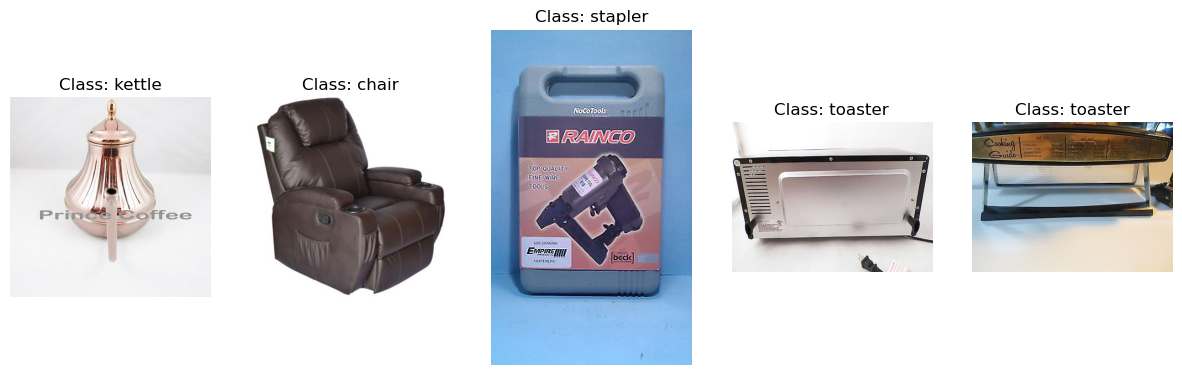

In [73]:
data_dir = 'Stanford_Online_Products'
train_paths = os.path.join(data_dir, 'Ebay_train.txt')
test_paths = os.path.join(data_dir, 'Ebay_test.txt')

train_df = pd.read_csv(train_paths, sep=' ', header=0)#names=['image_id', 'class_id', 'super_class_id', 'path'])

train_df = train_df.groupby('super_class_id').head(50)
train_df.reset_index(drop=True, inplace=True)

test_df = pd.read_csv(test_paths, sep=' ', header=0)# names=['image_id', 'class_id', 'super_class_id', 'path'])

# Select 5 random rows
random_rows = train_df.sample(n=5)

# Function to display images
def show_images(df):
    plt.figure(figsize=(15, 5))
    for i, row in enumerate(df.itertuples()):
        img_path = os.path.join(data_dir, row.path)
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Class: {class_names[int(row.super_class_id)]}')
        plt.axis('off')
    plt.show()

show_images(random_rows)

In [74]:
train_df.head()

,image_id,class_id,super_class_id,path
0,1,1,1,bicycle_final/111085122871_0.JPG
1,2,1,1,bicycle_final/111085122871_1.JPG
2,3,1,1,bicycle_final/111085122871_2.JPG
3,4,1,1,bicycle_final/111085122871_3.JPG
4,5,1,1,bicycle_final/111085122871_4.JPG


In [75]:
class StanfordOnlineProductsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data_dir  = 'Stanford_Online_Products'
        self.dataframe = dataframe
        self.transform = transform

        self.class_dict = {}
        for idx, class_id in enumerate(self.dataframe['class_id']):
            if class_id not in self.class_dict:
                self.class_dict[class_id] = []
            self.class_dict[class_id].append(idx)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        anchor_idx = idx
        anchor_img_path = os.path.join(self.data_dir, self.dataframe.iloc[anchor_idx, 3])
        anchor_image = Image.open(anchor_img_path).convert('RGB')
        anchor_class_id = int(self.dataframe.iloc[anchor_idx, 1])
        """
        # Get positive example
        positive_idx = anchor_idx
        while positive_idx == anchor_idx:
            positive_idx = np.random.choice(self.class_dict[anchor_class_id])
        positive_img_path = os.path.join(self.data_dir, self.dataframe.iloc[positive_idx, 3])
        positive_image = Image.open(positive_img_path).convert('RGB')

        # Get negative example
        negative_class_id = anchor_class_id
        while negative_class_id == anchor_class_id:
            negative_class_id = np.random.choice(list(self.class_dict.keys()))
        negative_idx = np.random.choice(self.class_dict[negative_class_id])
        negative_img_path = os.path.join(self.data_dir, self.dataframe.iloc[negative_idx, 3])
        negative_image = Image.open(negative_img_path).convert('RGB')
        """
        if self.transform:
            anchor_image = self.transform(anchor_image)
            #positive_image = self.transform(positive_image)
            #negative_image = self.transform(negative_image)

        return anchor_image, anchor_class_id
        #return (anchor_image, positive_image, negative_image), anchor_class_id

In [76]:
from torch.utils.data import Sampler
from collections import defaultdict

class StanfordOnlineProductsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data_dir = 'Stanford_Online_Products'
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.dataframe.iloc[idx, 3])
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label
    
class BalancedBatchSampler(Sampler):
    def __init__(self, dataframe, batch_size, shuffle=False):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.class_dict = defaultdict(list)
        self.shuffle = shuffle

        for idx, class_id in enumerate(dataframe['class_id']):
            self.class_dict[class_id].append(idx)

    def __iter__(self):
        indices = []
        for class_id, idx_list in self.class_dict.items():
            indices.extend(idx_list)
        
        if self.shuffle:
            random.shuffle(indices)

        # Ensuring at least one positive pair in each batch
        batch = []
        for idx in indices:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        
        if len(batch) > 0:
            yield batch

    def __len__(self):
        return len(self.dataframe) // self.batch_size

In [77]:
batch_size = 64

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = StanfordOnlineProductsDataset(dataframe=train_df, transform=transform)
test_dataset = StanfordOnlineProductsDataset(dataframe=test_df, transform=transform)

train_sampler = BalancedBatchSampler(train_df, batch_size, shuffle=True)
test_sampler = BalancedBatchSampler(test_df, batch_size)

train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=0,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_sampler=test_sampler,  num_workers=0,pin_memory=True)

#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=14,pin_memory=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=14,pin_memory=True)

In [78]:
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super(EmbeddingNet, self).__init__()
        self.resnet = models.resnet18(weights='DEFAULT')

        self.resnet.fc = nn.Identity()  
        self.fc = nn.Linear(512, embedding_dim) 

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)  
        x = F.normalize(x, p=2, dim=1)
        return x

In [79]:
from online_triplet_loss.losses import *

class EmbeddingModel(pl.LightningModule):
    def __init__(self, embedding_dim=128, margin=1.0, learning_rate=0.001):
        super(EmbeddingModel, self).__init__()
        self.model = EmbeddingNet(embedding_dim)
        self.margin = margin
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(self.device)
        images_emb = self.model(images)
        loss = batch_hard_triplet_loss(labels, images_emb, margin=self.margin)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
    def on_epoch_end(self):
        avg_loss = self.trainer.callback_metrics.get('train_loss')
        print(f'Epoch {self.current_epoch}: Average Loss: {avg_loss:.4f}')

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

In [80]:
len(train_loader)

9

In [81]:
print(device)

cuda


In [82]:
logging.basicConfig(level=logging.INFO)
logger = TensorBoardLogger("tb_logs", name="my_model")

torch.set_float32_matmul_precision('medium')

lightning_model = EmbeddingModel(embedding_dim=32)

checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    dirpath='model_checkpoints',
    filename='model-{epoch:02d}-{train_loss:.2f}',
    save_top_k=3,
    mode='min'
)

progress_bar = ProgressBar()

trainer = Trainer(max_epochs=1000, 
                  num_nodes=1 if torch.cuda.is_available() else 0, 
                  precision='16-mixed', 
                  default_root_dir='model_checkpoints',
                  callbacks=[checkpoint_callback, progress_bar],
                  logger=logger
)

trainer.fit(lightning_model, train_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs\my_model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EmbeddingNet | 11.2 M
---------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.772    Total estimated model params size (MB)
c:\Users\opala\miniconda3\envs\ml\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\opala\miniconda3\envs\ml\Lib\sit

In [ ]:
checkpoint_path = 'model_checkpoints/model-epoch=19-train_loss=0.18.ckpt'

# Load the model from the checkpoint
lightning_model = EmbeddingModel.load_from_checkpoint(checkpoint_path)

# Move the model to the appropriate device if necessary
lightning_model = lightning_model.to('cuda' if torch.cuda.is_available() else 'cpu')

In [83]:
lightning_model.to(device)
deviz = next(lightning_model.parameters()).device
print(f"The model is on device: {deviz}")

The model is on device: cuda:0


In [84]:
from tqdm import tqdm

def extract_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    labels = []
    indices = []
    with torch.no_grad(), tqdm(total=len(dataloader), desc="Processing Batches") as pbar:
        for i, batch in enumerate(dataloader):
            images, batch_labels = batch
            images = images.to(device)
            indices.extend([idx for idx in range(i * len(images), (i + 1) * len(images))])
            emb = model.model(images)
            embeddings.append(emb.cpu())
            labels.append(batch_labels.cpu())
            pbar.update(1)
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels, indices

test_embeddings, test_labels, test_indices = extract_embeddings(test_loader, lightning_model, device)

Processing Batches: 946it [05:14,  3.01it/s]                         


In [18]:
def calculate_top_n_accuracy(test_embeddings, test_labels,  N=1):
    correct = 0
    total = len(test_labels)

    for i in range(total):
        query_embedding = test_embeddings[i]
        query_label = test_labels[i]

        distances = torch.norm(test_embeddings - query_embedding, dim=1)
        sorted_indices = torch.argsort(distances)
        
        # Exclude the query image itself by starting from index 1
        top_n_indices = sorted_indices[1:N+1]
        
        if query_label in test_labels[top_n_indices]:
            correct += 1
    
    accuracy = correct / total
    return accuracy

top1_accuracy = calculate_top_n_accuracy(test_embeddings, test_labels, N=1)
print(f'Top-1 Accuracy: {100.*top1_accuracy:.4f}%')
top5_accuracy = calculate_top_n_accuracy(test_embeddings, test_labels, N=5)
print(f'Top-5 Accuracy: {100.*top5_accuracy:.4f}%')

Top-1 Accuracy: 8.6989%


KeyboardInterrupt: 

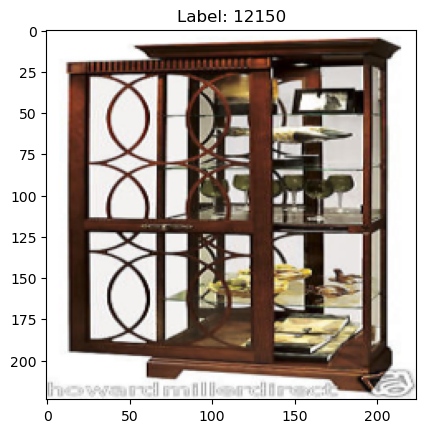

In [104]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


image, label = test_dataset[random.randint(0, len(test_dataset) - 1)]
show_image = denormalize(image, mean, std)

plt.imshow(show_image.permute(1, 2, 0))  # Assuming the image is a tensor in CHW format
plt.title(f"Label: {label}")
plt.show()

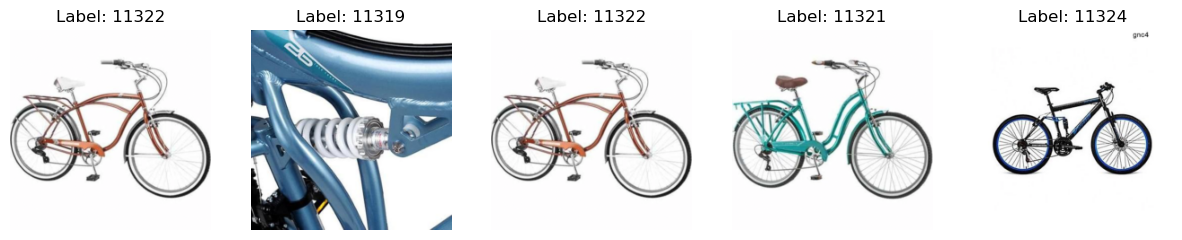

In [105]:
embedding = lightning_model.model(image.unsqueeze(0).to(device)).to('cpu')

distances = torch.norm(test_embeddings - embedding[0], dim=0)
sorted_indices = torch.argsort(distances)

# Exclude the query image itself by starting from index 1
top_n_indices = sorted_indices[1:5+1]
plt.figure(figsize=(15, 5))

for i, idx in enumerate(top_n_indices):

    close_img, close_label = test_dataset[idx.item()]
    show_close_image = denormalize(close_img, mean, std)
    plt.subplot(1, 5, i + 1)
    plt.imshow(show_close_image.permute(1, 2, 0))
    plt.title(f'Label: {close_label}')
    plt.axis('off')
plt.show()

In [62]:
idx.item()

42462

In [ ]:
def get_embedding(model, img, device):
    model.eval()
    with torch.no_grad():
        img = img.to(device)
        embedding = model.embedding_net(img.unsqueeze(0))
    return embedding.cpu().numpy()

# Example usage
test_img_path = 'path_to_test_image.jpg'
test_img = Image.open(test_img_path).convert('RGB')
test_img = transform(test_img)

embedding = get_embedding(model, test_img, device)
print(embedding)


In [ ]:
import pandas as pd

# Assume `embeddings` is a list of embeddings for each test image
embeddings = []

for img_path in test_file_paths:
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    embedding = get_embedding(model, img, device)
    embeddings.append(embedding.flatten())

# Convert to DataFrame and save to CSV
df = pd.DataFrame(embeddings)
df.to_csv('embeddings.csv', index=False)
